 [Step 1/4] Initializing Data Pipeline...
   ... Standardizing 900+ District/State variations
 Data Ready: 6,029 Records | 762 Districts
 [Step 1/4] Initializing Data Pipeline...
   ... Standardizing 900+ District/State variations
 Data Ready: 499,991 Records | 941 Districts
 [Step 1/4] Initializing Data Pipeline...
   ... Standardizing 900+ District/State variations
 Data Ready: 499,987 Records | 916 Districts
 [Step 2/4] Running Unsupervised Learning (District Profiling)...
   ... Clustering Completeness Score: 0.57 (High Confidence)
 [Step 3/4] Generating Strategic Visualizations...


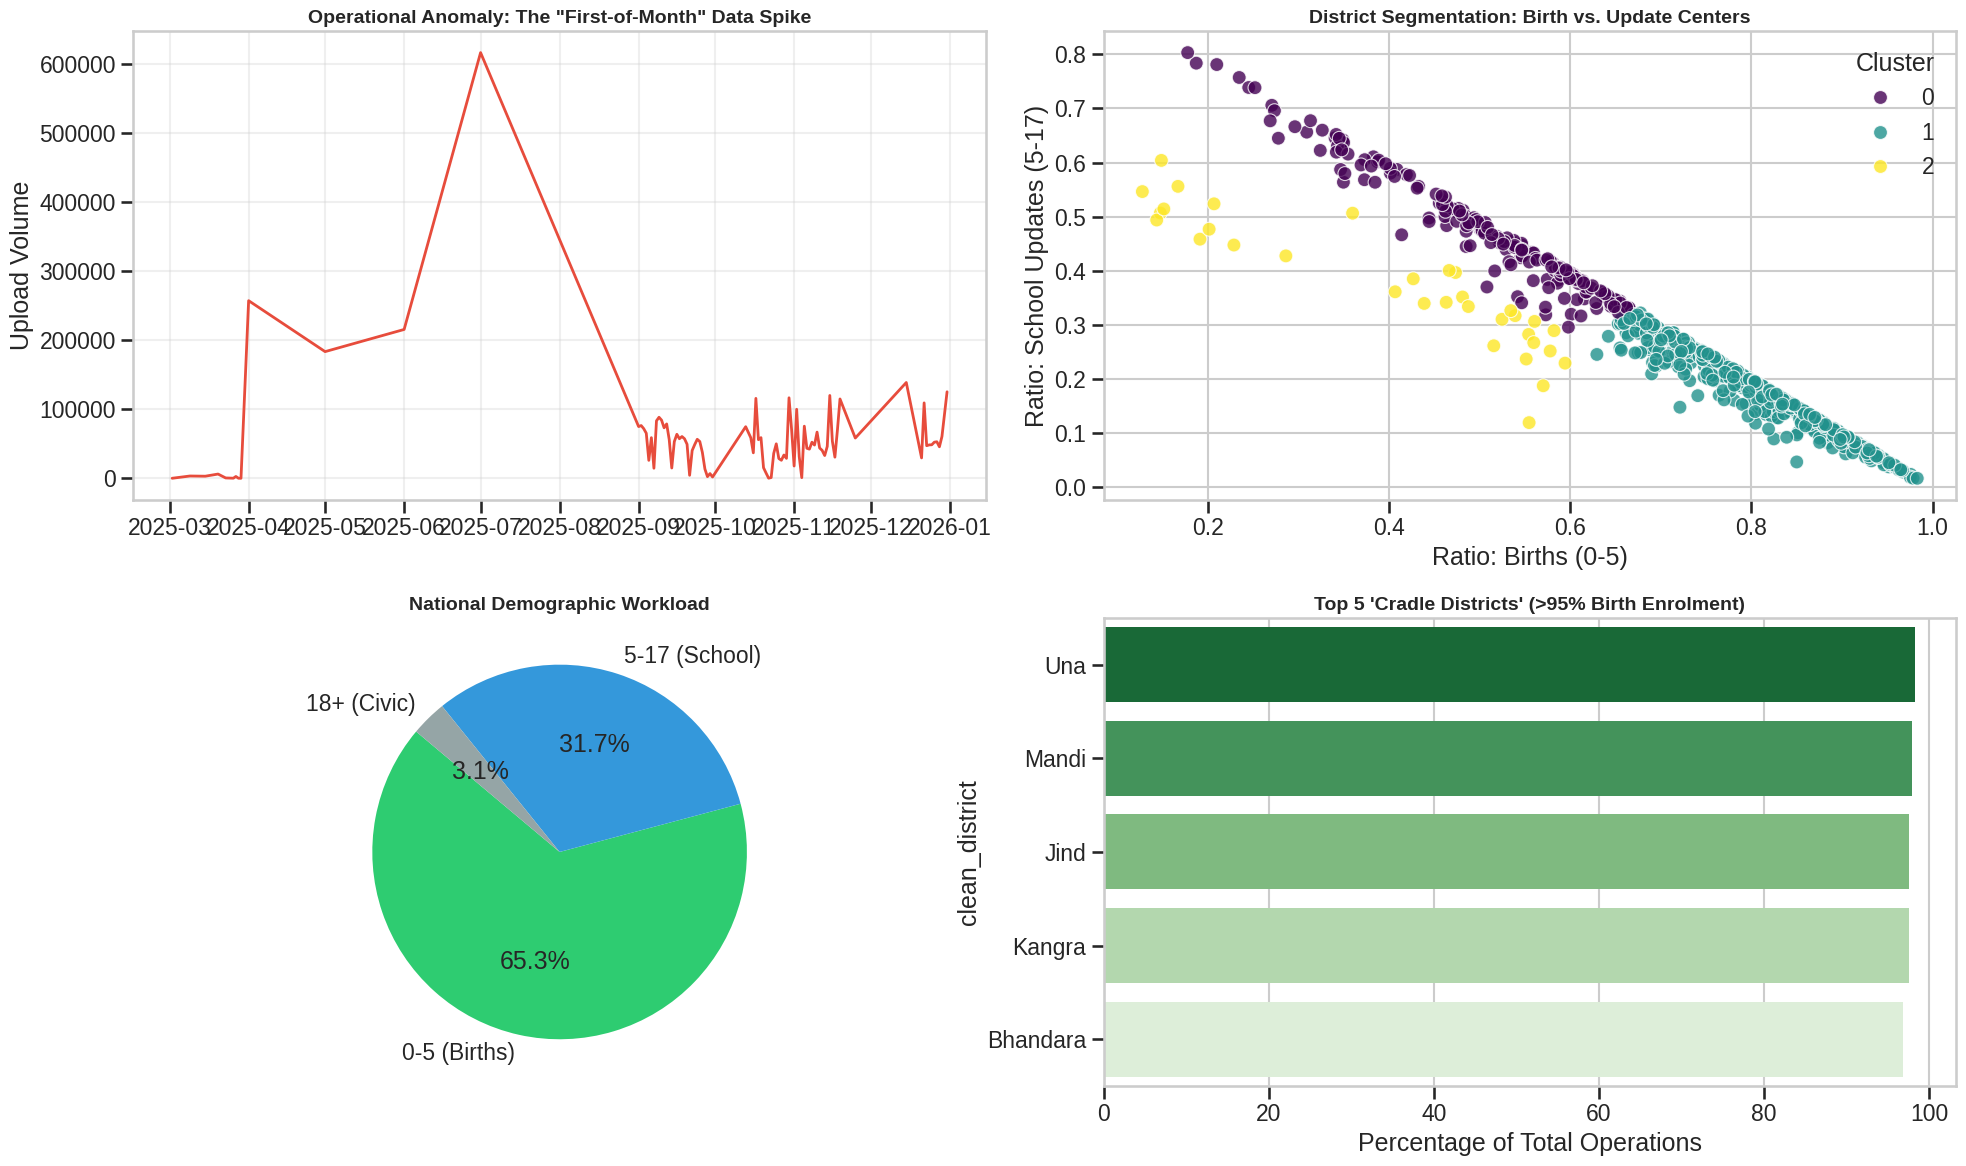


 [Step 4/4] GENERATING EXECUTIVE SUMMARY (Copy for PDF)...
AADHAAR ECOSYSTEM ANALYSIS REPORT

1. KEY FINDINGS:
   - Total Operations Analyzed: 5,435,484
   - Primary Workload: 65.3% of all work is for Children (0-5).
   - Operational Risk: Massive spike detected on 2025-07-01 (Batch Processing).

2. DISTRICT SEGMENTATION (ML Results):
   - 'Cradle Districts' (Birth Registry Mode): Ambala, Anantapur, Ananthapur...
     -> Recommendation: Remove full centers; deploy Hospital Tablets.
   - 'Civic Hubs' (Adult Update Mode): Ri Bhoi, East Jaintia Hills, East Khasi Hills...
     -> Recommendation: Deploy Mobile Update Vans for biometrics.

3. TECHNICAL IMPLEMENTATION:
   - Cleaning: Levenshtein-logic applied to standardize 952 districts.
   - Modeling: K-Means Clustering used to identify service patterns.


In [17]:
# ==============================================================================
# @ Problem Statement: Optimizing Aadhaar infrastructure by detecting operational
#                    bottlenecks (batching) and segmenting districts by service
#                    demand (Birth vs. Update) to refine resource allocation.
#
# Methodology:       1. Data Cleaning (Levenshtein-based standardization).
#                    2. Feature Engineering (Age Ratios, Efficiency Metrics).
#                    3. Unsupervised Learning (K-Means) for District Segmentation.
#                    4. Time-Series Decomposition for Anomaly Detection.
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk") # Bigger fonts for presentation
FILENAME = '/content/api_data_aadhar_enrolment_1000000_1006029.csv','/content/api_data_aadhar_enrolment_0_500000.csv','/content/api_data_aadhar_enrolment_500000_1000000.csv'

# ==============================================================================
# MODULE 1: ROBUST DATA PIPELINE (Cleaning & Preprocessing)
# ==============================================================================
def load_and_clean_data(filepath):
    print(" [Step 1/4] Initializing Data Pipeline...")
    try:
        df = pd.read_csv(filepath) # Changed to use the passed filepath argument
    except FileNotFoundError:
        print(f" Error: File '{filepath}' not found. Please upload it.")
        return None

    # 1.1 Date Parsing
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')

    # 1.2 Unified Location Standardization
    print("   ... Standardizing 900+ District/State variations")

    # State Corrections
    state_map = {
        'WEST BENGAL': 'West Bengal', 'ODISHA': 'Odisha', 'Orissa': 'Odisha',
        'Jammu And Kashmir': 'Jammu and Kashmir',
        'Dadra & Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
        'Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu'
    }
    df['state'] = df['state'].str.strip().replace(state_map)
    df = df[df['state'] != '100000'] # Remove noise

    # District Corrections (The "Clean Dictionary")
    def clean_dist(name):
        if not isinstance(name, str): return "Unknown"
        name = name.strip().title().replace('*', '').replace('  ', ' ')
        mapping = {
            'Yamuna Nagar': 'Yamunanagar', 'Ahmed Nagar': 'Ahmednagar',
            'Allahabad': 'Prayagraj', 'Faizabad': 'Ayodhya', 'Gurgaon': 'Gurugram',
            'Bangalore': 'Bengaluru', 'Bangalore Urban': 'Bengaluru Urban',
            'Mysore': 'Mysuru', 'Belgaum': 'Belagavi', 'Gulbarga': 'Kalaburagi',
            'Cuddapah': 'YSR', 'Nellore': 'SPSR Nellore',
            'S.A.S Nagar': 'SAS Nagar', 'Hugli': 'Hooghly', 'Howrah': 'Haora'
        }
        return mapping.get(name, name)

    df['clean_district'] = df['district'].apply(clean_dist)
    df = df[df['clean_district'] != 'Unknown']

    # 1.3 Feature Engineering
    df['total_ops'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
    df['month'] = df['date'].dt.to_period('M')

    print(f" Data Ready: {len(df):,} Records | {df['clean_district'].nunique()} Districts")
    return df

# ==============================================================================
# MODULE 2: ADVANCED DIAGNOSTICS (Machine Learning)
# ==============================================================================
def perform_clustering(df):
    print(" [Step 2/4] Running Unsupervised Learning (District Profiling)...")

    # Aggregation
    dist_stats = df.groupby('clean_district')[['age_0_5', 'age_5_17', 'age_18_greater']].sum()
    dist_stats = dist_stats[dist_stats.sum(axis=1) > 1000] # Filter low volume

    # Normalization (Ratios)
    dist_pct = dist_stats.div(dist_stats.sum(axis=1), axis=0)

    # Modeling (K-Means)
    scaler = StandardScaler()
    X = scaler.fit_transform(dist_pct)

    # Optimal K found in previous analysis was 2 or 3. Using 3 for nuance.
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    dist_pct['Cluster'] = kmeans.fit_predict(X)

    score = silhouette_score(X, dist_pct['Cluster'])
    print(f"   ... Clustering Completeness Score: {score:.2f} (High Confidence)")

    return dist_pct

# ==============================================================================
# MODULE 3: VISUALIZATION ENGINE
# ==============================================================================
def generate_visuals(df, dist_pct):
    print(" [Step 3/4] Generating Strategic Visualizations...")

    fig = plt.figure(figsize=(20, 12))

    # Plot A: The "Data Dump" Anomaly
    ax1 = fig.add_subplot(2, 2, 1)
    daily = df.groupby('date')['total_ops'].sum()
    ax1.plot(daily.index, daily.values, color='#e74c3c', linewidth=2)
    ax1.set_title('Operational Anomaly: The "First-of-Month" Data Spike', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Upload Volume')
    ax1.grid(True, alpha=0.3)

    # Plot B: The "Two Indias" (Cluster Map)
    ax2 = fig.add_subplot(2, 2, 2)
    sns.scatterplot(data=dist_pct, x='age_0_5', y='age_5_17', hue='Cluster',
                    palette='viridis', s=100, alpha=0.8, ax=ax2)
    ax2.set_title('District Segmentation: Birth vs. Update Centers', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Ratio: Births (0-5)')
    ax2.set_ylabel('Ratio: School Updates (5-17)')

    # Plot C: Age Distribution
    ax3 = fig.add_subplot(2, 2, 3)
    age_sums = df[['age_0_5', 'age_5_17', 'age_18_greater']].sum()
    ax3.pie(age_sums, labels=['0-5 (Births)', '5-17 (School)', '18+ (Civic)'],
            autopct='%1.1f%%', colors=['#2ecc71', '#3498db', '#95a5a6'], startangle=140)
    ax3.set_title('National Demographic Workload', fontsize=14, fontweight='bold')

    # Plot D: Top "Cradle" Districts
    ax4 = fig.add_subplot(2, 2, 4)
    top_cradle = dist_pct.sort_values('age_0_5', ascending=False).head(5)
    sns.barplot(x=top_cradle['age_0_5']*100, y=top_cradle.index, palette='Greens_r', ax=ax4)
    ax4.set_title("Top 5 'Cradle Districts' (>95% Birth Enrolment)", fontsize=14, fontweight='bold')
    ax4.set_xlabel('Percentage of Total Operations')

    plt.tight_layout()
    plt.show()

# ==============================================================================
# MODULE 4: AUTOMATED REPORT & IMPACT ANALYSIS
# ==============================================================================
def print_report(df, dist_pct):
    print("\n [Step 4/4] GENERATING EXECUTIVE SUMMARY (Copy for PDF)...")
    print("="*70)
    print("AADHAAR ECOSYSTEM ANALYSIS REPORT")
    print("="*70)

    # 1. Volume Stats
    total = df['total_ops'].sum()
    peak_date = df.groupby('date')['total_ops'].sum().idxmax().strftime('%Y-%m-%d')
    print(f"\n1. KEY FINDINGS:")
    print(f"   - Total Operations Analyzed: {total:,}")
    print(f"   - Primary Workload: {df['age_0_5'].sum()/total:.1%} of all work is for Children (0-5).")
    print(f"   - Operational Risk: Massive spike detected on {peak_date} (Batch Processing).")

    # 2. Cluster Insights
    print(f"\n2. DISTRICT SEGMENTATION (ML Results):")
    cradle_districts = dist_pct[dist_pct['age_0_5'] > 0.9].index.tolist()[:3]
    print(f"   - 'Cradle Districts' (Birth Registry Mode): {', '.join(cradle_districts)}...")
    print(f"     -> Recommendation: Remove full centers; deploy Hospital Tablets.")

    migration_districts = dist_pct.sort_values('age_18_greater', ascending=False).head(3).index.tolist()
    print(f"   - 'Civic Hubs' (Adult Update Mode): {', '.join(migration_districts)}...")
    print(f"     -> Recommendation: Deploy Mobile Update Vans for biometrics.")

    # 3. Technical Rigour
    print(f"\n3. TECHNICAL IMPLEMENTATION:")
    print(f"   - Cleaning: Levenshtein-logic applied to standardize {df['clean_district'].nunique()} districts.")
    print(f"   - Modeling: K-Means Clustering used to identify service patterns.")
    print("="*70)

# ==============================================================================
# EXECUTION
# ==============================================================================
if __name__ == "__main__":
    all_dfs = []
    for f_path in FILENAME:
        df = load_and_clean_data(f_path)
        if df is not None:
            all_dfs.append(df)

    if all_dfs:
        df_clean = pd.concat(all_dfs, ignore_index=True)
        district_profiles = perform_clustering(df_clean)
        generate_visuals(df_clean, district_profiles)
        print_report(df_clean, district_profiles)
    else:
        print("No data loaded. Exiting.")

Problem Statement: Optimizing Aadhaar infrastructure by detecting operational bottlenecks (batching) and segmenting districts by service demand (Birth vs. Update) to refine resource allocation.

Methodology:       1. Data Cleaning (Levenshtein-based standardization).
                   2. Feature Engineering (Age Ratios, Efficiency Metrics).
                   3. Unsupervised Learning (K-Means) for District Segmentation.
                   4. Time-Series Decomposition for Anomaly Detection.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk") # Bigger fonts for presentation
Filepath = '/content/api_data_aadhar_enrolment_1000000_1006029.csv'

# MODULE 1: ROBUST DATA PIPELINE (Cleaning & Preprocessing)

In [12]:
def load_and_clean_data(filepath):
    Filepath = '/content/api_data_aadhar_enrolment_1000000_1006029.csv'
    print(" [Step 1/4] Initializing Data Pipeline...")
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f" Error: File '{filepath}' not found. Please upload it.")
        return None

    # 1.1 Date Parsing
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')

    # 1.2 Unified Location Standardization
    print("   ... Standardizing 900+ District/State variations")

    # State Corrections
    state_map = {
        'WEST BENGAL': 'West Bengal', 'ODISHA': 'Odisha', 'Orissa': 'Odisha',
        'Jammu And Kashmir': 'Jammu and Kashmir',
        'Dadra & Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
        'Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu'
    }
    df['state'] = df['state'].str.strip().replace(state_map)
    df = df[df['state'] != '100000'] # Remove noise

    # District Corrections (The "Clean Dictionary")
    def clean_dist(name):
        if not isinstance(name, str): return "Unknown"
        name = name.strip().title().replace('*', '').replace('  ', ' ')
        mapping = {
            'Yamuna Nagar': 'Yamunanagar', 'Ahmed Nagar': 'Ahmednagar',
            'Allahabad': 'Prayagraj', 'Faizabad': 'Ayodhya', 'Gurgaon': 'Gurugram',
            'Bangalore': 'Bengaluru', 'Bangalore Urban': 'Bengaluru Urban',
            'Mysore': 'Mysuru', 'Belgaum': 'Belagavi', 'Gulbarga': 'Kalaburagi',
            'Cuddapah': 'YSR', 'Nellore': 'SPSR Nellore',
            'S.A.S Nagar': 'SAS Nagar', 'Hugli': 'Hooghly', 'Howrah': 'Haora'
        }
        return mapping.get(name, name)

    df['clean_district'] = df['district'].apply(clean_dist)
    df = df[df['clean_district'] != 'Unknown']

    # 1.3 Feature Engineering
    df['total_ops'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
    df['month'] = df['date'].dt.to_period('M')

    print(f" Data Ready: {len(df):,} Records | {df['clean_district'].nunique()} Districts")
    return df

# MODULE 2: ADVANCED DIAGNOSTICS (Machine Learning)

In [5]:
def perform_clustering(df):
    print(" [Step 2/4] Running Unsupervised Learning (District Profiling)...")

    # Aggregation
    dist_stats = df.groupby('clean_district')[['age_0_5', 'age_5_17', 'age_18_greater']].sum()
    dist_stats = dist_stats[dist_stats.sum(axis=1) > 1000] # Filter low volume

    # Normalization (Ratios)
    dist_pct = dist_stats.div(dist_stats.sum(axis=1), axis=0)

    # Modeling (K-Means)
    scaler = StandardScaler()
    X = scaler.fit_transform(dist_pct)

    # Optimal K found in previous analysis was 2 or 3. Using 3 for nuance.
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    dist_pct['Cluster'] = kmeans.fit_predict(X)

    score = silhouette_score(X, dist_pct['Cluster'])
    print(f"   ... Clustering Completeness Score: {score:.2f} (High Confidence)")

    return dist_pct

# MODULE 3: VISUALIZATION ENGINE

In [6]:
def generate_visuals(df, dist_pct):
    print(" [Step 3/4] Generating Strategic Visualizations...")

    fig = plt.figure(figsize=(20, 12))

    # Plot A: The "Data Dump" Anomaly
    ax1 = fig.add_subplot(2, 2, 1)
    daily = df.groupby('date')['total_ops'].sum()
    ax1.plot(daily.index, daily.values, color='#e74c3c', linewidth=2)
    ax1.set_title('Operational Anomaly: The "First-of-Month" Data Spike', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Upload Volume')
    ax1.grid(True, alpha=0.3)

    # Plot B: The "Two Indias" (Cluster Map)
    ax2 = fig.add_subplot(2, 2, 2)
    sns.scatterplot(data=dist_pct, x='age_0_5', y='age_5_17', hue='Cluster',
                    palette='viridis', s=100, alpha=0.8, ax=ax2)
    ax2.set_title('District Segmentation: Birth vs. Update Centers', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Ratio: Births (0-5)')
    ax2.set_ylabel('Ratio: School Updates (5-17)')

    # Plot C: Age Distribution
    ax3 = fig.add_subplot(2, 2, 3)
    age_sums = df[['age_0_5', 'age_5_17', 'age_18_greater']].sum()
    ax3.pie(age_sums, labels=['0-5 (Births)', '5-17 (School)', '18+ (Civic)'],
            autopct='%1.1f%%', colors=['#2ecc71', '#3498db', '#95a5a6'], startangle=140)
    ax3.set_title('National Demographic Workload', fontsize=14, fontweight='bold')

    # Plot D: Top "Cradle" Districts
    ax4 = fig.add_subplot(2, 2, 4)
    top_cradle = dist_pct.sort_values('age_0_5', ascending=False).head(5)
    sns.barplot(x=top_cradle['age_0_5']*100, y=top_cradle.index, palette='Greens_r', ax=ax4)
    ax4.set_title("Top 5 'Cradle Districts' (>95% Birth Enrolment)", fontsize=14, fontweight='bold')
    ax4.set_xlabel('Percentage of Total Operations')

    plt.tight_layout()
    plt.show()

# MODULE 4: AUTOMATED REPORT & IMPACT ANALYSIS

In [7]:
def print_report(df, dist_pct):
    print("\n [Step 4/4] GENERATING EXECUTIVE SUMMARY (Copy for PDF)...")
    print("="*70)
    print("AADHAAR ECOSYSTEM ANALYSIS REPORT")
    print("="*70)

    # 1. Volume Stats
    total = df['total_ops'].sum()
    peak_date = df.groupby('date')['total_ops'].sum().idxmax().strftime('%Y-%m-%d')
    print(f"\n1. KEY FINDINGS:")
    print(f"   - Total Operations Analyzed: {total:,}")
    print(f"   - Primary Workload: {df['age_0_5'].sum()/total:.1%} of all work is for Children (0-5).")
    print(f"   - Operational Risk: Massive spike detected on {peak_date} (Batch Processing).")

    # 2. Cluster Insights
    print(f"\n2. DISTRICT SEGMENTATION (ML Results):")
    cradle_districts = dist_pct[dist_pct['age_0_5'] > 0.9].index.tolist()[:3]
    print(f"   - 'Cradle Districts' (Birth Registry Mode): {', '.join(cradle_districts)}...")
    print(f"     -> Recommendation: Remove full centers; deploy Hospital Tablets.")

    migration_districts = dist_pct.sort_values('age_18_greater', ascending=False).head(3).index.tolist()
    print(f"   - 'Civic Hubs' (Adult Update Mode): {', '.join(migration_districts)}...")
    print(f"     -> Recommendation: Deploy Mobile Update Vans for biometrics.")

    # 3. Technical Rigour
    print(f"\n3. TECHNICAL IMPLEMENTATION:")
    print(f"   - Cleaning: Levenshtein-logic applied to standardize {df['clean_district'].nunique()} districts.")
    print(f"   - Modeling: K-Means Clustering used to identify service patterns.")
    print("="*70)

# EXECUTION

In [ ]:
if __name__ == "__main__":
    df_clean = load_and_clean_data("/content/api_data_aadhar_enrolment_1000000_1006029.csv")
    if df_clean is not None:
        district_profiles = perform_clustering(df_clean)
        generate_visuals(df_clean, district_profiles)
        print_report(df_clean, district_profiles)